# Predicting penalties during an NFL football game.  

In this notebook we explore the 'model_data.csv' (constructed in the data_gathering_and_combining_1week.ipynb notebook) file to see what we can gather in terms of penalties being called during a play on a given down during the first week of the NFL football season. One of the main reason that we considered only the first week is due to computational resources. Having at least more than one week in the data would result in more than 2 million records to consider. Our idea is that we can apply the methods done in this notebook to other weeks of the NFL season as well. 

The target variable column in the data is 'penaltyCodes'. The penalties we examnined were Defensive Pass Interference (DPI), Offensive Pass Interference (OPI), Illegal Contact (ICT), and Defensive Holding (DH). We flag the column with a 1 if any of the penalties occurred and 0 if not. Supervised learning classification methods were the main tools used here. The features we will use for our eventual model are: 'yardsToGo', 'defendersInTheBox', 'numberOfPassRushers', 'passResult',	'offensePlayResult', 'x', 'y', 'a', 'dis', 'o', 'dir', 'defender', and 'coverage_count'. We used various classification methods and show the results of logistic regression, Random Forest, AdaBoost, and a Gradient Boosted classifier models. The Gradient Boosted Classifier ended up being the optimal model since it had the highest recall score. Recall comes into question here because of the imbalanced target variable. We want to make sure that we get as many of the flagged (i.e. 1's) from the validation data as possible.   

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
#Read in the requisite file
new_df=pd.read_csv('../model_data.csv')

/Users/andrewcastillo/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
#creating the target variable on the penaltyCodes column

#0 if no penalty,1 if there was a penalty. 
new_df['penaltyCodes']=new_df.penaltyCodes.fillna(0)
new_df['penaltyCodes']=new_df.penaltyCodes.apply(lambda x: 0 if x==0 else 1)

In [5]:
pd.set_option('display.max_columns', None)
new_df.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,new_Id,defender,coverage_count,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN,2018090600_75,False,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,2018090600_75,True,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,2018090600_75,False,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,2018090600_75,True,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,2018090600_75,False,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False


In [55]:
new_df.sample(10)

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,new_Id,defender,coverage_count,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
26264,2018-09-07T02:21:02.200Z,71.70,12.42,4.01,3.79,0.39,36.07,346.97,None,2539653.0,Robert Alford,23.0,CB,28,away,2018090600,1801,left,NaN,2018090600_1801,True,7,(1:35) (Shotgun) N.Foles pass incomplete short...,2,3,3,PHI,play_type_pass,PHI,36,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,6.0,3.0,01:35:00,74.0,0,NaN,I,0,0,-0.782217,False
180227,2018-09-09T17:48:20.200Z,42.38,26.53,5.22,4.91,0.55,2.84,59.63,None,2560713.0,Tremaine Edmunds,49.0,LB,44,away,2018090900,1161,left,NaN,2018090900_1161,True,7,(14:03) J.Flacco pass incomplete short middle ...,2,1,10,BAL,play_type_pass,BUF,20,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,5.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,0.0,14.0,14:03:00,30.0,0,NaN,I,0,0,-0.216527,False
700742,2018-09-10T23:11:29.299Z,91.85,26.81,4.96,2.34,0.48,212.28,193.40,None,2495328.0,Bilal Powell,29.0,RB,25,away,2018091000,60,left,FLAT,2018091000_60,False,8,(14:53) S.Darnold pass short left intended for...,1,1,10,NYJ,play_type_pass,NYJ,25,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,4.0,"3 DL, 3 LB, 5 DB",SCRAMBLE_ROLLOUT_RIGHT,0.0,0.0,14:53:00,85.0,0,NaN,IN,0,0,-8.011549,False
82629,2018-09-09T17:06:31.599Z,16.68,35.63,1.47,2.09,0.15,77.30,255.04,None,2556367.0,William Jackson,22.0,CB,21,away,2018090902,163,left,NaN,2018090902_163,True,7,(13:18) (Shotgun) A.Luck pass short left inten...,1,2,14,IND,play_type_pass,CIN,14,SHOTGUN,"1 RB, 2 TE, 2 WR",6.0,4.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,0.0,0.0,13:18:00,24.0,0,NaN,IN,0,0,-3.771753,False
561548,2018-09-09T22:18:23.299Z,47.40,16.85,8.49,0.64,0.85,236.96,227.19,None,2543830.0,Tre Boston,33.0,FS,52,home,2018090909,2430,right,NaN,2018090909_2430,True,7,(9:12) A.Smith pass incomplete short right to ...,3,1,10,WAS,play_type_pass,WAS,28,SINGLEBACK,"1 RB, 3 TE, 1 WR",8.0,5.0,"4 DL, 2 LB, 5 DB",DESIGNED_ROLLOUT_RIGHT,21.0,0.0,09:12:00,38.0,0,NaN,I,0,0,-0.549421,False
552667,2018-09-09T22:04:25.200Z,22.64,42.32,2.45,5.02,0.22,250.79,285.34,None,2539932.0,Jamar Taylor,28.0,CB,29,home,2018090909,2084,right,NaN,2018090909_2084,True,7,(12:25) A.Smith pass incomplete short left to ...,3,3,14,WAS,play_type_pass,WAS,4,SINGLEBACK,"1 RB, 2 TE, 2 WR",8.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,21.0,0.0,12:25:00,14.0,0,NaN,I,0,0,-1.042581,False
195278,2018-09-09T17:55:34.400Z,31.73,33.45,4.49,3.04,0.43,76.13,87.86,play_action,2557863.0,Zay Jones,11.0,WR,21,away,2018090900,1316,right,HITCH,2018090900_1316,False,9,(12:20) (Shotgun) N.Peterman pass incomplete d...,2,2,14,BUF,play_type_pass,BUF,21,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0.0,17.0,12:20:00,31.0,0,NaN,I,0,0,-0.879525,False
7665,2018-09-07T01:29:06.000Z,21.46,25.00,2.60,1.46,0.27,265.86,119.81,None,2507828.0,Logan Paulsen,82.0,TE,35,away,2018090600,545,left,NaN,2018090600_545,False,7,(5:38) M.Ryan pass incomplete short left.,1,2,7,ATL,play_type_pass,PHI,7,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,05:38:00,17.0,0,NaN,I,0,0,-0.360976,False
431871,2018-09-09T19:54:49.299Z,56.53,38.96,2.44,6.42,0.23,255.50,323.28,None,2560970.0,Jessie Bates,30.0,DB,40,away,2018090902,3962,right,NaN,2018090902_3962,True,7,(3:47) (Shotgun) A.Luck pass short left to J.D...,4,3,10,IND,play_type_pass,IND,25,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,27.0,23.0,03:47:00,35.0,0,NaN,C,12,12,1.694048,False
294381,2018-09-09T18:49:49.500Z,83.24,42.72,0.84,0.25,0.08,162.55,318.71,None,2533062.0,Stephon Gilmore,24.0,CB,10,home,2018090905,2345,left,NaN,2018090905_2345,True,8,(14:23) (Shotgun) D.Watson pa

In [7]:
#Plays data frame 
plays_df=pd.read_csv('../nfl_data/plays.csv')
pd.set_option('display.max_columns', None)
plays_df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",TRADITIONAL,0.0,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


In [8]:
#look at the description of the personnelD
new_df.personnelD.value_counts()

4 DL, 2 LB, 5 DB          292968
3 DL, 3 LB, 5 DB          202617
4 DL, 3 LB, 4 DB          112395
2 DL, 4 LB, 5 DB           98988
2 DL, 3 LB, 6 DB           54795
3 DL, 4 LB, 4 DB           36330
3 DL, 2 LB, 6 DB           33324
4 DL, 1 LB, 6 DB           32396
1 DL, 5 LB, 5 DB           15744
1 DL, 3 LB, 7 DB           15327
1 DL, 4 LB, 6 DB            7824
0 DL, 6 LB, 5 DB            4437
0 DL, 5 LB, 6 DB            3026
3 DL, 1 LB, 7 DB            2800
3 DL, 1 LB, 6 DB, 1 TE      1946
4 DL, 4 LB, 3 DB             806
5 DL, 2 LB, 4 DB             732
5 DL, 1 LB, 5 DB             552
6 DL, 3 LB, 2 DB             517
5 DL, 3 LB, 3 DB             506
Name: personnelD, dtype: int64

In [9]:
#gathering the relavent information for the top 8 most used defensive personnel 
#This was based off of most used personnel on the defensive line 
rel_def=list(new_df.personnelD.value_counts().index[:8])
new_df=new_df.loc[new_df['personnelD'].isin(rel_def)].reset_index().drop('index', axis=1)

In [10]:
new_df.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,new_Id,defender,coverage_count,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN,2018090600_75,False,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,2018090600_75,True,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,2018090600_75,False,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,2018090600_75,True,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,2018090600_75,False,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False


In [11]:
#look at the description of the personnelO
new_df.personnelO.value_counts()

1 RB, 1 TE, 3 WR          600133
1 RB, 2 TE, 2 WR          156135
2 RB, 1 TE, 2 WR           38859
1 RB, 3 TE, 1 WR           26072
1 RB, 0 TE, 4 WR           11700
2 RB, 2 TE, 1 WR           11070
0 RB, 1 TE, 4 WR            5936
2 RB, 0 TE, 3 WR            4367
3 RB, 1 TE, 1 WR            2072
6 OL, 1 RB, 1 TE, 2 WR      1944
0 RB, 2 TE, 3 WR            1469
6 OL, 2 RB, 0 TE, 2 WR      1079
2 QB, 0 RB, 1 TE, 3 WR       988
1 RB, 1 TE, 2 WR,1 DL        754
6 OL, 1 RB, 2 TE, 1 WR       624
2 QB, 1 RB, 1 TE, 2 WR       611
Name: personnelO, dtype: int64

In [12]:
#gathering the relavent information for the top 6 most used offensive personnel 
#these personnel mainly consist of 11, 12, 21, spread, and 22 personnel. 
rel_off=list(new_df.personnelO.value_counts().index[:6])
new_df=new_df.loc[new_df['personnelO'].isin(rel_off)].reset_index().drop('index', axis=1)

In [13]:
new_df.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,new_Id,defender,coverage_count,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN,2018090600_75,False,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,2018090600_75,True,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,2018090600_75,False,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,2018090600_75,True,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,2018090600_75,False,7,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,0,NaN,C,10,10,0.261827,False


In [14]:
#penaltyCodes on the data frame 
new_df.penaltyCodes.value_counts()

0    777200
1     66769
Name: penaltyCodes, dtype: int64

# Modeling Phase

In [6]:
#Scorers
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, make_scorer

#for cross validation 
from sklearn.model_selection import cross_val_score

In [7]:
#These are the features we will use to predict the penalties. 
features=['yardsToGo', 'defendersInTheBox', 'numberOfPassRushers', 
          'passResult', 'offensePlayResult', 
          'x', 'y', 'a', 'dis', 'o', 'dir', 'defender', 'coverage_count', 'penaltyCodes']

In [8]:
#create the base data frame
df_model=new_df[features]

In [9]:
df_model.head()

,yardsToGo,defendersInTheBox,numberOfPassRushers,passResult,offensePlayResult,x,y,a,dis,o,dir,defender,coverage_count,penaltyCodes
0,15,7.0,4.0,C,10,91.73,26.67,0.01,0.02,289.57,240.93,False,7,0
1,15,7.0,4.0,C,10,88.89,36.47,0.01,0.01,105.63,66.66,True,7,0
2,15,7.0,4.0,C,10,91.35,44.16,0.03,0.01,290.45,16.86,False,7,0
3,15,7.0,4.0,C,10,86.31,22.01,0.42,0.01,70.12,168.91,True,7,0
4,15,7.0,4.0,C,10,90.78,36.15,0.00,0.00,257.61,193.97,False,7,0


In [10]:
#there are missing defenders in the box 
#we will fill in those missing values with the columns corresponding means.  
df_model.isnull().sum()

yardsToGo                  0
defendersInTheBox       2850
numberOfPassRushers    39013
passResult                 0
offensePlayResult          0
x                          0
y                          0
a                          0
dis                        0
o                          0
dir                        0
defender                   0
coverage_count             0
penaltyCodes               0
dtype: int64

In [11]:
#average number of defenders in the box 
df_model.defendersInTheBox.mean()

6.039473554966445

In [12]:
#fill in the missing values in the defenders in the box column with the mean value 
df_model['defendersInTheBox']=df_model.defendersInTheBox.fillna(6)

<ipython-input-12-8ba961a0d479>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['defendersInTheBox']=df_model.defendersInTheBox.fillna(6)


In [13]:
#average number of pass rushers 
df_model.numberOfPassRushers.mean()

4.152712885866996

In [14]:
#fill in the missing values in the defenders in the box column with the mean value 
df_model['numberOfPassRushers']=df_model.numberOfPassRushers.fillna(4)

<ipython-input-14-8859cf7aebb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['numberOfPassRushers']=df_model.numberOfPassRushers.fillna(4)


In [15]:
#check to make sure that the data is no longer missing values 
df_model.isnull().sum()

yardsToGo              0
defendersInTheBox      0
numberOfPassRushers    0
passResult             0
offensePlayResult      0
x                      0
y                      0
a                      0
dis                    0
o                      0
dir                    0
defender               0
coverage_count         0
penaltyCodes           0
dtype: int64

In [16]:
#get the one hot encoded variables (on the pass result column)
df_dum=pd.get_dummies(df_model)
df_dum.head()

,yardsToGo,defendersInTheBox,numberOfPassRushers,offensePlayResult,x,y,a,dis,o,dir,defender,coverage_count,penaltyCodes,passResult_C,passResult_I,passResult_IN,passResult_S
0,15,7.0,4.0,10,91.73,26.67,0.01,0.02,289.57,240.93,False,7,0,1,0,0,0
1,15,7.0,4.0,10,88.89,36.47,0.01,0.01,105.63,66.66,True,7,0,1,0,0,0
2,15,7.0,4.0,10,91.35,44.16,0.03,0.01,290.45,16.86,False,7,0,1,0,0,0
3,15,7.0,4.0,10,86.31,22.01,0.42,0.01,70.12,168.91,True,7,0,1,0,0,0
4,15,7.0,4.0,10,90.78,36.15,0.00,0.00,257.61,193.97,False,7,0,1,0,0,0


In [17]:
#create the feature matrix and target variable as well as the train test split 
from sklearn.model_selection import train_test_split

X = df_dum.drop('penaltyCodes', axis =1)
y = df_dum.penaltyCodes

#Create the train-test split 
X_train,X_val,y_train,y_val = train_test_split(X,y,shuffle = True,stratify = y,
                                                train_size=0.70,
                                                random_state = 42)

### Logistic Regression Model 

In [57]:
#logistic regression
from sklearn.linear_model import LogisticRegression
lr_clf=LogisticRegression(max_iter=10000)

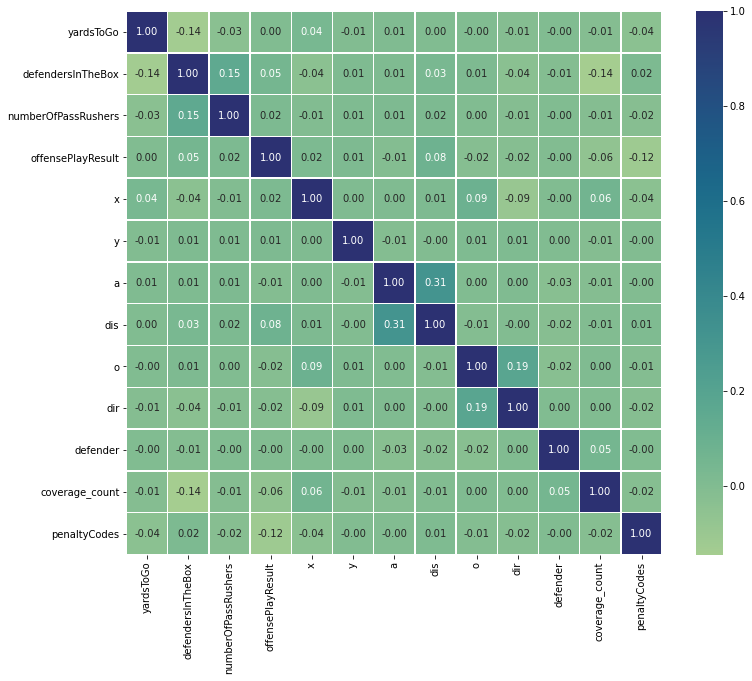

In [28]:
#plot a heat map for logistic regression to check for multicollinearity 
plt.figure(figsize=(12,10))
cmap=sns.color_palette("crest", as_cmap=True)
sns.heatmap(df_model.corr(), annot=True, fmt = ".2f", linewidth=0.5, cmap=cmap)
plt.show()

In [29]:
#created a function to calculate the model scores for logistic regression 
def log_reg_model_scores(model, cutoff, X_t=X_train, y_t=y_train, X_v=X_val, y_v=y_val): 
    """Get the model scores for logistic regression"""
    
    # Preprocessing of training data, fit model (ONE LINE MENTIONED ABOVE)
    model.fit(X_t, y_t)
    
    # store the predicted probabilities
    #Probability that 0 in the first column, probability that 1 in the second column 
    #Reason why we want to write [:, 1] is because we want the 1's not the 0's.
    
    y_prob = model.predict_proba(X_v)[:,1]
    
    #Predictions
    y_pred=1*(y_prob>cutoff)
    
    #Accuracy Score
    accuracy=accuracy_score(y_v, y_pred)
    
    #Precision Score
    precision=precision_score(y_v, y_pred)
    
    #Recall Score
    recall=recall_score(y_v, y_pred)
    
    #AUC Score
    #y_prob=my_pipeline.predict_proba(X_v)[:,1]
    
    auc_score=roc_auc_score(y_v,y_prob)
    
    
    scores=np.array([accuracy, precision, recall, auc_score])
    
    df = pd.DataFrame(scores,
                     columns=['Scores'], index=['Accuracy', 'Precision', 'Recall', 'AUC'])
    return df

In [58]:
#get the cutoffs for logistic regression 
cutoffs_lg=list(np.arange(.1,.5, .1))
cutoffs_lg

[0.1, 0.2, 0.30000000000000004, 0.4]

In [59]:
#Model Scores for the validation data
for cutoff in cutoffs_lg: 
    print(f'{lr_clf} training scores with cutoff {cutoff}:')
    print(log_reg_model_scores(lr_clf, cutoff, X_train, y_train, X_val, y_val))
    print('\n') 

LogisticRegression(max_iter=10000) training scores with cutoff 0.1:
             Scores
Accuracy   0.673973
Precision  0.157334
Recall     0.716489
AUC        0.716515


LogisticRegression(max_iter=10000) training scores with cutoff 0.2:
             Scores
Accuracy   0.902489
Precision  0.178670
Recall     0.064650
AUC        0.716515


LogisticRegression(max_iter=10000) training scores with cutoff 0.30000000000000004:
             Scores
Accuracy   0.920412
Precision  0.000000
Recall     0.000000
AUC        0.716515


LogisticRegression(max_iter=10000) training scores with cutoff 0.4:
             Scores
Accuracy   0.920886
Precision  0.000000
Recall     0.000000
AUC        0.716515




/Users/andrewcastillo/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model is doing a good job with the accuracy but the recall and precision are becoming undefined. This probably is a result of the class imbalance. The model in some sense is doing a great job at predicing the non penalties (0) but not so a great job at predicing the penalties (at least at the higher cutoff levels).  

### Random forest classification 

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
#Function we will use to get model metrics. 
def get_model_scores(model, X_t, y_t, X_v, y_v): 
    """Get accuracy, precision, recall, AUC, scores for designated model"""

    # Fit the data 
    model.fit(X_t, y_t)

    # Get predictions
    y_pred = model.predict(X_v)
    
    #Accuracy Score
    accuracy=accuracy_score(y_v, y_pred)
    
    #Precision Score
    precision=precision_score(y_v, y_pred)
    
    #Recall Score
    recall=recall_score(y_v, y_pred)
    
    #AUC Score
    y_prob=model.predict_proba(X_v)
    
    auc_score=roc_auc_score(y_v,y_prob[:,1])
    
    
    scores=np.array([accuracy, precision, recall, auc_score])
    
    df = pd.DataFrame(scores,
               
                      columns=['Scores'], index=['Accuracy', 'Precision', 'Recall', 'AUC'])
    return df

In [33]:
#create the base model 
rf_clf=RandomForestClassifier(max_depth=20, random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=0)

In [34]:
#create the random forest classifier predictions
rf_clf_pred=rf_clf.predict(X_val)
rf_clf_prob=rf_clf.predict_proba(X_val)

In [35]:
#get model scores 
get_model_scores(rf_clf, X_train, y_train, X_val, y_val)

,Scores
Accuracy,0.980315
Precision,0.999403
Recall,0.751635
AUC,0.999019


In [37]:
#cross validation on the random forest classifier for the recall metric: 
recall_scores=cross_val_score(rf_clf, X_train, y_train,
                              cv=5,
                              scoring='recall')
print(f"Random Forest Classifier recall scores: {recall_scores}")
print(f"Random Forest Classifier mean recall score: {np.mean(recall_scores)}\n")

Random Forest Classifier recall scores: [0.74037227 0.73063757 0.73438169 0.74355408 0.74130737]
Random Forest Classifier mean recall score: 0.7380505960944131



In [36]:
## Feature Importance
# Make a feature importance dataframe
# then it displays it in order of decreasing importance
names = []
scores = []
for name, score in zip(X_val.columns,rf_clf.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score
0,yardsToGo,0.2173
3,offensePlayResult,0.1545
4,x,0.1415
1,defendersInTheBox,0.1117
2,numberOfPassRushers,0.0761
11,coverage_count,0.0732
5,y,0.0438
9,dir,0.0387
8,o,0.0322
12,passResult_C,0.0279


It seems like the random forest model is performing well but could be a bit prone to high variance. Let's take a look at other models to be sure. If another model can give up a little bias for some more stable variance, that model may be optimal. 

### Ada Boost Classifier

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                n_estimators = 50,
                                algorithm="SAMME.R",
                                learning_rate = 0.5)

In [39]:
## Fit the model here
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5)

In [40]:
#get the prediction 
ada_clf_pred = ada_clf.predict(X_val)

In [41]:
#for AUC score 
y_prob_ada=ada_clf.predict_proba(X_val)

In [42]:
print('The accuracy score is', accuracy_score(y_val, ada_clf_pred))
print('The precision score is', precision_score(y_val, ada_clf_pred))
print('The recall score is', recall_score(y_val, ada_clf_pred))
print('The AUC score is', roc_auc_score(y_val,y_prob_ada[:,1]))

The accuracy score is 0.9202973249444095
The precision score is 0.0
The recall score is 0.0
The AUC score is 0.8154315558696681


In [43]:
## Feature Importance
# Make a feature importance dataframe
# then it displays it in order of decreasing importance
names = []
scores = []
for name, score in zip(X_val.columns,ada_clf.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score
0,yardsToGo,0.32
3,offensePlayResult,0.30
2,numberOfPassRushers,0.16
1,defendersInTheBox,0.12
4,x,0.04
11,coverage_count,0.02
12,passResult_C,0.02
15,passResult_S,0.02
5,y,0.00
6,a,0.00


From the model scores as well as feature importance metrics, it looks like the ADA boost model is not doing a good job at getting the scores. The importance it places on features is not allowing the model to make a accurate prediction on the precision and recall. 

### Gradient Boosted Classifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf=GradientBoostingClassifier(max_depth = 5,
                                n_estimators = 100,
                                learning_rate=.5, random_state=0)

In [20]:
#fit and get the model predictions 
gb_clf.fit(X_train, y_train)

y_pred=gb_clf.predict(X_val)

In [46]:
#get probablities 
y_prob_gb=gb_clf.predict_proba(X_val)

In [47]:
print('Accuracy Score of Gradient Boosted Classifier', accuracy_score(y_val, y_pred))

print('Precision Score of Gradient Boosted Classifier', precision_score(y_val, y_pred))

print('Recall Score of Gradient Boosted Classifier', recall_score(y_val, y_pred))

print('AUC score of Gradient Boosted Classifier is', roc_auc_score(y_val,y_prob_gb[:,1]))

Accuracy Score of Gradient Boosted Classifier 0.981808200133496
Precision Score of Gradient Boosted Classifier 0.9630741519063344
Recall Score of Gradient Boosted Classifier 0.8007588238230743
AUC score of Gradient Boosted Classifier is 0.9961712752764523


In [60]:
#Cross validation on accuracy scores 
accuracy_scores=cross_val_score(gb_clf, X_train, y_train,
                              cv=5,
                              scoring='accuracy')
print(f"Gradient Boosted Classifier accuracy scores: {accuracy_scores}")
print(f"Gradient Boosted Classifier mean accuracy score: {np.mean(accuracy_scores)}\n")

Gradient Boosted Classifier accuracy scores: [0.98028031 0.98059345 0.98091506 0.98132115 0.98076256]
Gradient Boosted Classifier mean accuracy score: 0.980774505033521



In [62]:
#Cross validation on recall scores 
recall_scores=cross_val_score(gb_clf, X_train, y_train,
                              cv=5,
                              scoring='recall')
print(f"Gradient Boosted Classifier recall scores: {recall_scores}")
print(f"Gradient Boosted Classifier mean recall score: {np.mean(recall_scores)}\n")

Gradient Boosted Classifier recall scores: [0.78198545 0.78572957 0.79107831 0.80132663 0.78688349]
Gradient Boosted Classifier mean recall score: 0.7894006891339514



In [64]:
#Cross validation on precision scores 
precision_scores=cross_val_score(gb_clf, X_train, y_train,
                              cv=5,
                              scoring='precision')
print(f"Gradient Boosted Classifier precision scores: {precision_scores}")
print(f"Gradient Boosted Classifier mean precision score: {np.mean(precision_scores)}\n")

Gradient Boosted Classifier precision scores: [0.96158906 0.96201703 0.96076393 0.95535714 0.96320063]
Gradient Boosted Classifier mean precision score: 0.960585557564101



In [21]:
#Cross validation on f1 scores 
f1_scores=cross_val_score(gb_clf, X_train, y_train,
                              cv=5,
                              scoring='f1')
print(f"Gradient Boosted Classifier f1 scores: {f1_scores}")
print(f"Gradient Boosted Classifier mean f1 score: {np.mean(f1_scores)}\n")

Gradient Boosted Classifier f1 scores: [0.86947865 0.87506573 0.85781059 0.86337931 0.87123   ]
Gradient Boosted Classifier mean f1 score: 0.8673928566286822



In [22]:
#Print the classification report 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("confusion matrix")
print(conf_matrix)
print("-------------------------------------------")
print(classification_report(y_val,y_pred))

confusion matrix
[[252732    711]
 [  4634  17656]]
-------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    253443
           1       0.96      0.79      0.87     22290

    accuracy                           0.98    275733
   macro avg       0.97      0.89      0.93    275733
weighted avg       0.98      0.98      0.98    275733



The gradient boosted classifier seems to do the best with the highest recall. That metric is what we care about since there is a target variable imbalance. Since it can catch the most flagged values (i.e. the '1's), we will use this model as the final model. 

### Analyze Feature Importance of the  Gradient Boosted Model 

In [48]:
## Feature Importance
# Make a feature importance dataframe
# then it displays it in order of decreasing importance
names = []
scores = []
for name, score in zip(X_val.columns,gb_clf.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score
0,yardsToGo,0.2049
3,offensePlayResult,0.1944
1,defendersInTheBox,0.1265
4,x,0.0992
2,numberOfPassRushers,0.0967
11,coverage_count,0.0725
12,passResult_C,0.0583
15,passResult_S,0.0486
13,passResult_I,0.0451
14,passResult_IN,0.0260


In [65]:
from sklearn.linear_model import Lasso

In [80]:
# We will look at a Lasso regression model with small penalty values to gather more information on 
#feature importance. 

alphas = [0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001]

lasso_coefs = np.zeros((len(alphas), np.shape(X_train)[1]))

for i in range(len(alphas)):
    lasso = Lasso(alpha=alphas[i], normalize=True)
    
    lasso.fit(X_train,y_train)
    lasso_coefs[i,:] = lasso.coef_

In [83]:
## Look at how each coefficient changes here
print("Lasso Coefficients")

features1=list(X_train.columns)
pd.DataFrame(np.round(lasso_coefs,8),
             columns=features1,
            index = ["alpha=" + str(a) for a in alphas])

Lasso Coefficients


,yardsToGo,defendersInTheBox,numberOfPassRushers,offensePlayResult,x,y,a,dis,o,dir,defender,coverage_count,passResult_C,passResult_I,passResult_IN,passResult_S
alpha=1e-09,-0.001951,0.004122,-0.019799,0.000046,-0.000384,-0.000003,-0.001142,0.017447,-0.000003,-0.000052,0.000072,-0.008217,-0.111458,-0.004615,-0.027530,0.030381
alpha=1e-08,-0.001949,0.004114,-0.019782,0.000045,-0.000383,-0.000003,-0.001136,0.017407,-0.000003,-0.000052,0.000058,-0.008209,-0.106805,0.000000,-0.022862,0.034962
alpha=1e-07,-0.001935,0.004044,-0.019617,0.000029,-0.000381,-0.000000,-0.001073,0.017017,-0.000003,-0.000051,0.000000,-0.008139,-0.106450,0.000000,-0.022357,0.034602
alpha=1e-06,-0.001783,0.003305,-0.018130,-0.000000,-0.000352,-0.000000,-0.000406,0.012632,-0.000000,-0.000044,0.000000,-0.007417,-0.104473,0.000000,-0.017303,0.031717
alpha=1e-05,-0.000183,0.000000,-0.005040,-0.000000,-0.000070,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.091875,0.000000,-0.000000,0.003074
alpha=0.0001,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
alpha=0.001,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000


- Looking at the feature importance scores as well as the results of the Lasso Regression we can deduce the following: 
    - yardsToGo, offensePlayResult, defendersInTheBox, and coverage_count seemed to play the most important role in making the predicitions using this classifier. This seems to mean that those variables can contribute the most to a potential flag. 

- Let's now make a hypothesis for why this is the case for each of the features: 
    - __yardsToGo__: This seems to indicate that the down yardage can in some sense increase the probability for a penalty to occur. For example, when the offense is in third and long, they are prone to passing. Because of this, depending on coverage (which also appears as an important feature), the receiver may be in a 1-1 pass scenario when the defensive back is prone to holding, grabbing or simply interfering. 
    - __coverage_count__: This feature indicates what we see throughout an NFL football game. The defense is prone to holding or interfering calls because of the increase in talent of the wide recievers entering the league. Far too often defensive backs are placed in tough 1-1 passing scenarios (low coverage situations or blitzing situations) and the only way to prevent a big play from happening may be to interfere with a route in some way. Hence, if there are less players in coverage situations, the more prone to a penalty the defense is. 
    - __defendersInTheBox__: This almost goes hand in hand with the coverage_count feature. The more defenders you have in the box at the initiation of a play, the more prone you are as a defense to be in man-to-man. Hence, the cornerbacks, slots, and/or safeties are placed in 1-1 situations resulting in penalties. 
    - __offensePlayResult__: This result could be an indicator of potential offensive pass interference. In order for a big play to occur (excluding penalties), the reciever, tight end, or running back may need to 'push off', 'pick' or be too aggresive at the point of contact. 